# Getting started

Assume the following system:

![setting](./figures/setting.svg?sanitize=true)

In order to simulate this system, we will define the single components
as python classes, combine them to a model, run a simulation
of the model.

The key objects to model a system are so called quantities.
It will be distinguished between the following:

- `StateQuantity`: For example the temperature in the
  tank. The evolution of state quantities are described by an ODE.
- `ComputedQuantity`: A variable whose value is determined by other
  quantities (the outgoing temperature is a function of the incoming
  temperatures and the position of the valve). Computed quantities are
  derived of present values of other arbitrary quantities. They are
  not determined by an ODE (directly).
- `ManipulatedVariable`: A variable which is set in periodic
  time intervals by a controlling process. *Example*: the position of
  the valve, the flow rate of the pump.
- `ExternalQuantity`: Quantities whose values are passed to the
  simulation from a data file or an other source. For example an
  ambient temperature ($T_2$ from the example above will be defined
  as `ExternalQuantity`).
- `ConstantQuantity`: A quantity with a constant value ($T_1$ will be defined
  as `ConstantQuantity`).
  
## Step 1: Python classes for components
We are going to need the following.

In [1]:
from DynamicalSystemKit.model import Model, Element, StateFunction, ManipulatedVariable, \
    ExternalQuantity, ComputedQuantity, \
    Derivative, DerivativeInline, ConstantQuantity, d_, t_sampler

**Pump**

In [2]:
class Pump(Element):
    def __init__(self):
        self.Phi = ManipulatedVariable(1)

**Mixing valve**
As the mixing valve has to know the incoming temperatures and the
outgoing flow, it takes the corresponding quantity objects as arguments.
On the other hand the quantity for the position is declared as a class
variable.
Note that the quantities `T_1` and `T_2` passed to
`__init__` together with the instance attribute
`position` will be used as annotations in
the definition of the computed quantity. This way, when building the
ODE, the function `T_out` will receive the correct arguments.
To declare the dimension of the return value a return annotation
`-> 1` is specified.
Also note, that the decorated function `T_out` is declared inside
`__init__` instead as a method in the class body.
The decorator turns `T_out` into a
`ComputedQuantity` object. Because it needs
access to the instance attributes `T_1`, `T_2` and
`Phi_out`, it cannot be declared as a class attribute.

In [3]:
class MixingValve(Element):
    def __init__(self, *args, T_1, T_2, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.position = ManipulatedVariable(1)

        @ComputedQuantity
        def T_out(T1: T_1, T2: T_2, position: self.position) -> 1:
            return T1 * position + T2 * (1. - position)
        self.T_out = T_out

*Attention*: At the time of writing, a `ComputedQuantity`
 will only work if the underlying function is vectorized. The reason
 behind this is that the function will be used during solving the ODE
 and again after the ODE solver is finished, i.e. if the values of the
 state functions are known. 
 During solving the ODE, the function is evaluated at single time values, but at
 the final call, it is evaluated at the whole time range of the
 simulation.
 At this stage, the simulation will fail, if the computation function
 is not vectorized.

**Tank**
The state of the tank is determined by its temperature $T$. The change
of $T$ is given by $\dot{T} = \Phi / V (T_\mathrm{in} -T)$, where $V$
is the volume of the tank. This ODE is modelled as a
`Derivative` object which is defined by annotated function of the form
of `dT` in the code below. All arguments must be given the origin
quantity as annotation as for computed quantities. The return
annotation indicates for which quantity the derivative is computed. To
emphasize, that the return value does not correspond to $T$ but to
$\dot{T}$, the `Quantity` object has to be wrapped by `d_`.


In [4]:
class Tank(Element):
    def __init__(self, *args, T_in, Phi, V, **kwargs):
        super().__init__(*args, **kwargs)
        self.T = StateFunction(1)

        @Derivative
        def dT(T: self.T, Phi_: Phi, T_i: T_in) -> d_(self.T):
            return Phi_ / V * (T_i - T)
        self.dT = dT

## Step 2: Compose the components to a model

The composing is done by create an instance of the `Model` class. Its
constructor accepts an arbitrary number of named arguments.
Top level `Quantity` objects have to be passed to the model before they can be
referenced by other `Element` objects. For this purpose, it is possible
to add additional `Element` objects to the model with the method `add`.

In [5]:
class ExampleModel(Model):
    T_1 = ConstantQuantity(10.)
    T_2 = ExternalQuantity(n=1)
    pump = Pump()
    valve = MixingValve(T_1=T_1, T_2=T_2)
    tank = Tank(V=1.0, T_in=valve.T_out, Phi=pump.Phi)

Finally, we define a controller callback, to set values for the
manipulated variables. This function will be called at user defined
times (see [below](#step-3-run-the-model)) and will receive the current values of the
simulation at the specific times.

In [6]:
from math import sin

def ctrl(t: ExampleModel.t, T: ExampleModel.tank.T,
          Phi: ExampleModel.pump.Phi[:],
          position: ExampleModel.valve.position[:]):
    Phi[:] = 0.5 if T < 10. else 1.0
    position[:] = sin(t)

Note the `[:]` in the arguments annotation (and in the code). If
omitted, `ctrl` would receive copied float instances instead of views to
the manipulated variables and nothing would be manipulated.

## Step 3: Run the model

To run, the model needs to know the time range of the simulation and
the initial values for all state
functions and manipulated variables, if present (it is assumed that new
values for manipulated variables depend on old values).
Moreover, if present, the external quantities and (the expressions thereof
formed by computed quantities) form the inhomogeneous part of the
ODE. Values for external quantities have to be provided in form of an
interpolant (which the ODE solver can evaluate at arbitrary t values).
Finally for the control callback, the simulation wants to know the
times at which the control function should be called. This information
is passed in form of a `sampler` function which takes the time range
of the simulation as arguments and returns the times of the control
calls.
The family of functions `model.t_sampler(Delta_t)` are predefined
`sampler` functions which generate a equidistant sequence of times
separated by `Delta_t`, starting at `t[0]` (if `t` is the range of the
simulation).
In the example below, `t_sampler(1.)` is used, resulting in the
control function being called every second.

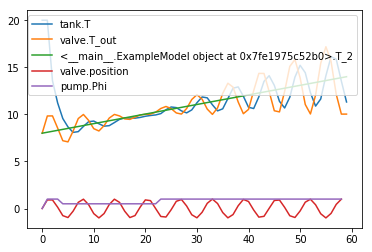

In [10]:
import numpy
x0 = {ExampleModel.tank.T: 20., ExampleModel.pump.Phi: 0., ExampleModel.valve.position: 0.}
t = numpy.arange(60.)
_T_2 = 8. + 6. / t[-1] * t
timeseries = ExampleModel.run(x0, t, external_quantity_data={ExampleModel.t: t, ExampleModel.T_2: _T_2},
                       f_ctrl=ctrl, t_ctrl_sampler=t_sampler(1.))

import matplotlib.pyplot as plt
plt.ion() # This is to show matplotlib inline in jupyter
for caption, (t, y) in timeseries.items():
    plt.plot(t, y, label=caption)
plt.legend()
plt.show()

# Advanced possibilities

## Multi dimensional quantities
## Derivative objects defining the change of multiple quantities
## Using an external controller